# EXPLORATORY DATA ANALYSIS ON TECH YOUTUBE CHANNELS USING YOUTUBE DATA API

# INTRODUCTION

In this project, we are going to conduct Exploratory Data Analysis(EDA) on video data from 3 YouTube channels namely, Marques Brownlee, Mrwhosetheboss and Dave2D. These are some of the biggest tech channels on YouTube that I personally enjoy watching in my free time. These tech YouTubers make videos reviewing technology including smartphones, laptops, game consoles and even electric cars.

We will utilize the YouTube Data API to retrieve video data such as video title, upload date, view count, like count, video duration and so on for every single video available on these channels.

This project will be divided into 3 parts:
- Part 1: Data Extraction using YouTube Data API
- Part 2: Data Preparation
- Part 3: Data Analysis

# PART 1: DATA EXTRACTION USING YOUTUBE DATA API

The information that we want to extract for each video such as video title, upload date, etc., can be retrieved using video IDs. A YouTube video ID is a unique string that contains information about a specific video. Here are the steps that we need to take in order to retrieve all the video IDs:
- Obtain the channel IDs. We will have 3 channel IDs in total.
- Use the channel IDs to obtain playlist IDs.
- Use the playlist IDs to obtain video IDs.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
plt.style.use('ggplot')

youtube = build("youtube", "v3", developerKey=key)

## Get Channel IDs

First, we need to go to any video posted on each channel and extract the video ID from the URL. The video ID is located right after the v= URL parameter. For example, when we go to Marques Brownlee's latest video page and look at the URL("https://www.youtube.com/watch?v=mv9afG2Dm9I"), the video ID is "mv9afG2Dm9I". We repeat this step for the other 2 channels.

In [3]:
latest_video_ids = ['mv9afG2Dm9I',  #Marques Brownlee
                    'nBZT7lF5dag',  #Dave2D
                    'CKvZ9KhLgHE',  #Mrwhosetheboss
                    ]

Now that we have a video ID for each channel, we can then obtain each channel's channel ID.

In [4]:
def get_channel_id(latest_video_ids):
    request = youtube.videos().list(part="snippet", id=','.join(latest_video_ids), maxResults=50)
    response = request.execute()

    channel_ids = []
    for item in response['items']:
        channel_id = item['snippet']['channelId']
        channel_ids.append(channel_id)

    return channel_ids

channel_ids = get_channel_id(latest_video_ids)
channel_ids

['UCBJycsmduvYEL83R_U4JriQ',
 'UCVYamHliCI9rw1tHR1xbkfw',
 'UCMiJRAwDNSNzuYeN2uWa0pA']

## Get Playlist IDs

Now, we can use the channel IDs to obtain the playlist ID for each channel. A playlist ID is a unique string that contains data on all the videos that are available on a YouTube channel. While doing this step, we'll also fetch a few other statistics related to each channel such as total views, subscribers and videos.

In [15]:
def get_playlist_id(channel_ids):
    request = youtube.channels().list(part="snippet,contentDetails,statistics", id=','.join(channel_ids), maxResults=50)
    response = request.execute()
    
    channel_info = []
    for item in response['items']:
        info = {'channel_name': item['snippet']['title'],
                'channel_id': item['id'],
                'views': item['statistics']['viewCount'],
                'subscribers': item['statistics']['subscriberCount'],
                'videos': item['statistics']['videoCount'],
                'uploads_playlist_id': item['contentDetails']['relatedPlaylists']['uploads']}
        channel_info.append(info)
        
    return pd.DataFrame(channel_info)

channel_info_df = get_playlist_id(channel_ids)
channel_info_df

,channel_name,channel_id,views,subscribers,videos,uploads_playlist_id
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,3451792477,16800000,1537,UUBJycsmduvYEL83R_U4JriQ
1,Mrwhosetheboss,UCMiJRAwDNSNzuYeN2uWa0pA,3138753607,14000000,1533,UUMiJRAwDNSNzuYeN2uWa0pA
2,Dave2D,UCVYamHliCI9rw1tHR1xbkfw,741254605,3610000,705,UUVYamHliCI9rw1tHR1xbkfw


The playlist ID for each channel can be retrieved from the above dataframe.

In [16]:
playlist_ids = list(channel_info_df.uploads_playlist_id)
playlist_ids

['UUBJycsmduvYEL83R_U4JriQ',
 'UUMiJRAwDNSNzuYeN2uWa0pA',
 'UUVYamHliCI9rw1tHR1xbkfw']

## Get Video IDs

The playlist IDs can now be used to obtain all the video IDs. Here, we have managed to extract 3772 video IDs.

In [17]:
def get_video_id(playlist_ids):
    all_video_ids = []
    for playlist_id in playlist_ids:
        request = youtube.playlistItems().list(part="contentDetails", maxResults=50, playlistId=playlist_id)
        response = request.execute()
        
        video_ids = []
        for item in response['items']:
            video_id = item['contentDetails']['videoId']
            video_ids.append(video_id)
        
        pageToken = response.get('nextPageToken')
        while pageToken is not None:
            request = youtube.playlistItems().list(part="contentDetails", maxResults=50, pageToken=pageToken, playlistId=playlist_id)
            response = request.execute()
            for item in response['items']:
                video_id = item['contentDetails']['videoId']
                video_ids.append(video_id)
            pageToken = response.get('nextPageToken')
        all_video_ids.append(video_ids)
    vid_ids = list(np.concatenate(all_video_ids))
    return vid_ids

vid_ids = get_video_id(playlist_ids)
len(vid_ids)

3772

## Get Video Statistics

Finally, we can use the video IDs to extract video statistics for every single video.

In [19]:
def get_video_info(vid_ids):
    video_ids = [vid_ids[i:i+50] for i in range(0, len(vid_ids), 50)]
    video_info = []
    for video_id in video_ids:
        request = youtube.videos().list(part="snippet,contentDetails,statistics", id=','.join(video_id), maxResults=50)
        response = request.execute()
        for item in response['items']:
            info = {'video_id': item['id'],
                    'channel_name': item['snippet']['channelTitle'],
                    'video_title': item['snippet']['title'],
                    'upload_date': item['snippet']['publishedAt'],
                    'duration': item['contentDetails']['duration'],
                    'view_count': item['statistics'].get('viewCount'),
                    'like_count': item['statistics'].get('likeCount'),
                    'comment_count': item['statistics'].get('commentCount')}
            video_info.append(info)
    return pd.DataFrame(video_info)

video_stats_df = get_video_info(vid_ids)
video_stats_df

,video_id,channel_name,video_title,upload_date,duration,view_count,like_count,comment_count
0,OkLOJapGjC4,Marques Brownlee,The ROG Phone 7 Ultimate is Just Ridiculous!,2023-04-13T12:30:43Z,PT10M49S,679789,38841,2169
1,wR-0knMVSGw,Marques Brownlee,The Rivian R1S Is... The Best SUV Ever?,2023-04-11T23:20:19Z,PT14M20S,1350115,53306,2788
2,HKvo6acp5aI,Marques Brownlee,The AI Assistant Battle! (2023),2023-04-08T04:45:06Z,PT15M44S,2086490,93668,4222
3,AFthdsIcOxw,Marques Brownlee,This Voice is Entirely AI...,2023-04-03T23:28:54Z,PT6M14S,1564051,74854,4378
4,17VcGk_-Ghc,Marques Brownlee,The Smartphone Awards Midseason 2023!,2023-04-01T12:14:04Z,PT7M35S,1345111,97879,7829
...,...,...,...,...,...,...,...,...
3767,5P5QwVlB2kg,Dave2D,Update No. 1 - Dell Venue 8 7840 Giveaway,2015-01-26T22:41:32Z,PT2M15S,11184,308,52
3768,XnFh3s74Dxg,Dave2D,Dell XPS 13 Review - 2015,2015-01-21T04:04:53Z,PT11M17S,268099,3248,544
3769,qL4vZjhwJsk,Dave2D,Using old SD Cards on the Panasonic GH4!,2015-01-15T20:40:14Z,PT1M40S,11645,212,22
3770,0NOcojVOgeI,Dave2D,Dell Venue 8 7000 Review,2015-01-15T02:37:11Z,PT4M31S,56989,874,142


# PART 2: DATA PREPARATION

In [20]:
df = video_stats_df.copy()
df.shape

(3772, 8)

We will start with dropping missing values, if we have any.

In [21]:
# Check for missing values.
df.isna().sum()

video_id          0
channel_name      0
video_title       0
upload_date       0
duration          0
view_count        7
like_count       13
comment_count    19
dtype: int64

In [22]:
# Drop missing values.
df = df.dropna().reset_index(drop=True)
df.shape

(3743, 8)

Now, we can work on converting a few columns into the proper data types.

In [23]:
df.dtypes

video_id         object
channel_name     object
video_title      object
upload_date      object
duration         object
view_count       object
like_count       object
comment_count    object
dtype: object

We'll first convert the upload_date column into datetime data type. Then, we will convert the view_count, like_count and comment_count into int data type.

In [24]:
# Convert upload_date to datetime
df['upload_date'] = pd.to_datetime(df.upload_date)

# Convert view_count, like_count and comment_count to int
numeric_cols = ['view_count', 'like_count', 'comment_count']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])

In [25]:
df.dtypes

video_id                      object
channel_name                  object
video_title                   object
upload_date      datetime64[ns, UTC]
duration                      object
view_count                     int64
like_count                     int64
comment_count                  int64
dtype: object

Now, we'll add additional columns that will assist our analysis later. First, we convert the duration into seconds and put it into duration_secs column. Next, we extract the day, month and year from the upload_date column.

In [26]:
# Convert duration to seconds.
import isodate
df['duration_secs'] = df.duration.apply(lambda x: isodate.parse_duration(x).total_seconds())

# Extract day, month and year from upload_date
df['day'] = df.upload_date.dt.day
df['month'] = df.upload_date.dt.month
df['year'] = df.upload_date.dt.year

In [27]:
df

,video_id,channel_name,video_title,upload_date,duration,view_count,like_count,comment_count,duration_secs,day,month,year
0,OkLOJapGjC4,Marques Brownlee,The ROG Phone 7 Ultimate is Just Ridiculous!,2023-04-13 12:30:43+00:00,PT10M49S,679789,38841,2169,649.0,13,4,2023
1,wR-0knMVSGw,Marques Brownlee,The Rivian R1S Is... The Best SUV Ever?,2023-04-11 23:20:19+00:00,PT14M20S,1350115,53306,2788,860.0,11,4,2023
2,HKvo6acp5aI,Marques Brownlee,The AI Assistant Battle! (2023),2023-04-08 04:45:06+00:00,PT15M44S,2086490,93668,4222,944.0,8,4,2023
3,AFthdsIcOxw,Marques Brownlee,This Voice is Entirely AI...,2023-04-03 23:28:54+00:00,PT6M14S,1564051,74854,4378,374.0,3,4,2023
4,17VcGk_-Ghc,Marques Brownlee,The Smartphone Awards Midseason 2023!,2023-04-01 12:14:04+00:00,PT7M35S,1345111,97879,7829,455.0,1,4,2023
...,...,...,...,...,...,...,...,...,...,...,...,...
3738,5P5QwVlB2kg,Dave2D,Update No. 1 - Dell Venue 8 7840 Giveaway,2015-01-26 22:41:32+00:00,PT2M15S,11184,308,52,135.0,26,1,2015
3739,XnFh3s74Dxg,Dave2D,Dell XPS 13 Review - 2015,2015-01-21 04:04:53+00:00,PT11M17S,268099,3248,544,677.0,21,1,2015
3740,qL4vZjhwJsk,Dave2D,Using old SD Cards on the Panasonic GH4!,2015-01-15 20:40:14+00:00,PT1M40S,11645,212,22,100.0,15,1,2015
3741,0NOcojVOgeI,Dave2D,Dell Venue 8 7000 Review,2015-01-15 02:37:11+00:00,PT4M31S,56989,874,142,271.0,15,1,2015


We'll also drop YouTube Short videos and only focus on long-form videos. This can be done by dropping videos that are less than a minute long, since YouTube Short only supports videos up to 60 seconds long.

In [28]:
df = df[df['duration_secs'] > 60].reset_index(drop=True)
df.shape

(3625, 12)

# PART 3: EXPLORATORY DATA ANALYSIS

## Number of Subscribers, Videos and Views per Channel

We will start by looking at channel statistics. We'll first convert the data types of a few columns from channel_info_df so we can visualize them.

In [30]:
cols = ['views', 'subscribers', 'videos']
for col in cols:
    channel_info_df[col] = pd.to_numeric(channel_info_df[col])

channel_info_df

,channel_name,channel_id,views,subscribers,videos,uploads_playlist_id
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,3451792477,16800000,1537,UUBJycsmduvYEL83R_U4JriQ
1,Mrwhosetheboss,UCMiJRAwDNSNzuYeN2uWa0pA,3138753607,14000000,1533,UUMiJRAwDNSNzuYeN2uWa0pA
2,Dave2D,UCVYamHliCI9rw1tHR1xbkfw,741254605,3610000,705,UUVYamHliCI9rw1tHR1xbkfw


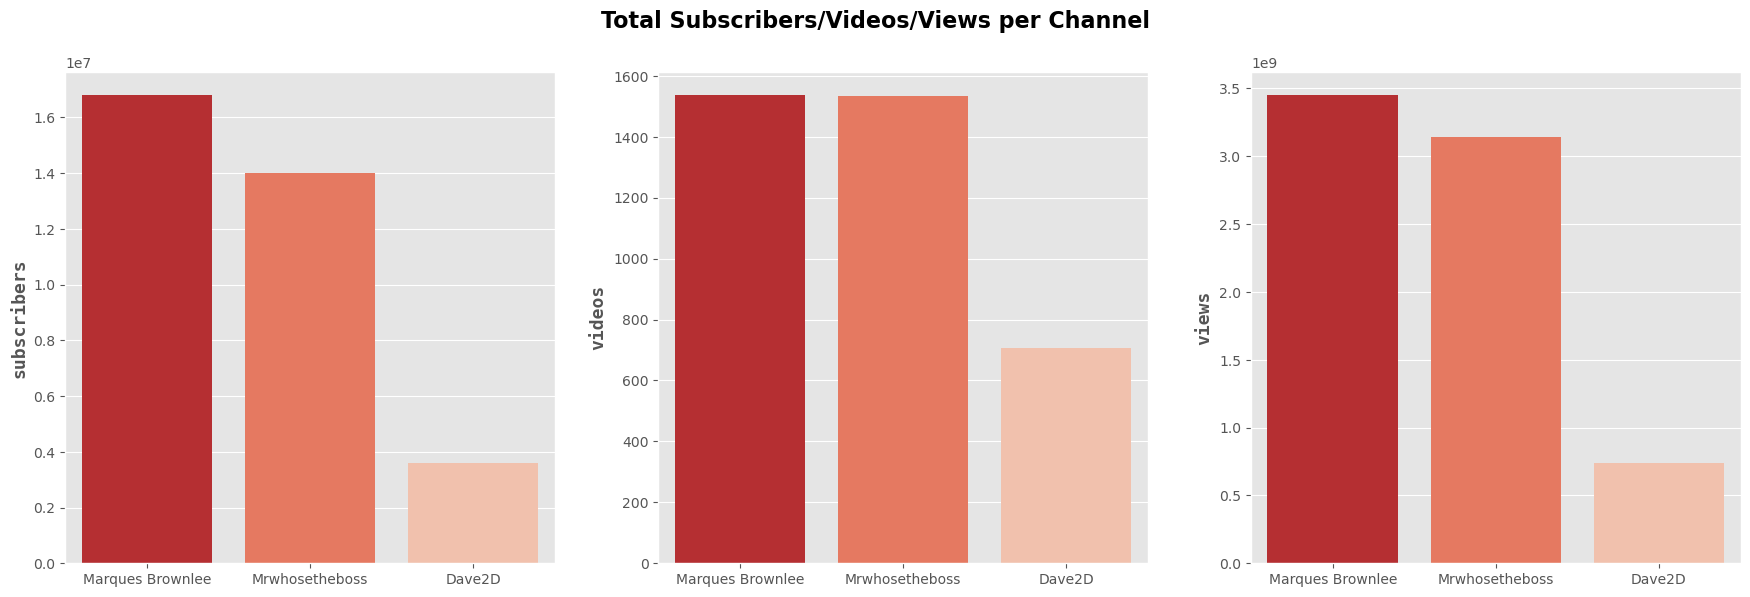

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fontdict = {'family': 'monospace', 'weight': 'bold', 'size': 13}

sns.barplot(data=channel_info_df, x='channel_name', y='subscribers', palette='Reds_r', ax=axes[0])
axes[0].set_xlabel(None)
axes[0].set_ylabel('subscribers', fontdict=fontdict)

sns.barplot(data=channel_info_df, x='channel_name', y='videos', palette='Reds_r', ax=axes[1])
axes[1].set_xlabel(None)
axes[1].set_ylabel('videos', fontdict=fontdict)

sns.barplot(data=channel_info_df, x='channel_name', y='views', palette='Reds_r', ax=axes[2])
axes[2].set_xlabel(None)
axes[2].set_ylabel('views', fontdict=fontdict)

plt.tight_layout(pad=2.5)
plt.suptitle('Total Subscribers/Videos/Views per Channel', size=16, weight='bold', y=1.02)
plt.show()

We can see that Marques Brownlee and Mrwhosetheboss are quite comparable in terms of number of subscribers, videos and views. On the other hand, Dave2D is a much smaller channel with less subscribers, videos and views.
For more context, let's look at the upload date for the first video on each channel.

In [33]:
df.groupby('channel_name')[['upload_date']].min()

,upload_date
channel_name,
Dave2D,2015-01-14 11:29:34+00:00
Marques Brownlee,2009-01-01 19:43:47+00:00
Mrwhosetheboss,2011-04-22 12:36:35+00:00


This may explain the size of each channel. Marques Brownlee is the oldest channel with the first video being uploaded on the channel in 2009. Mrwhosetheboss first uploaded a video in 2011, and Dave2D in 2015.

## Distribution of Views per Channel

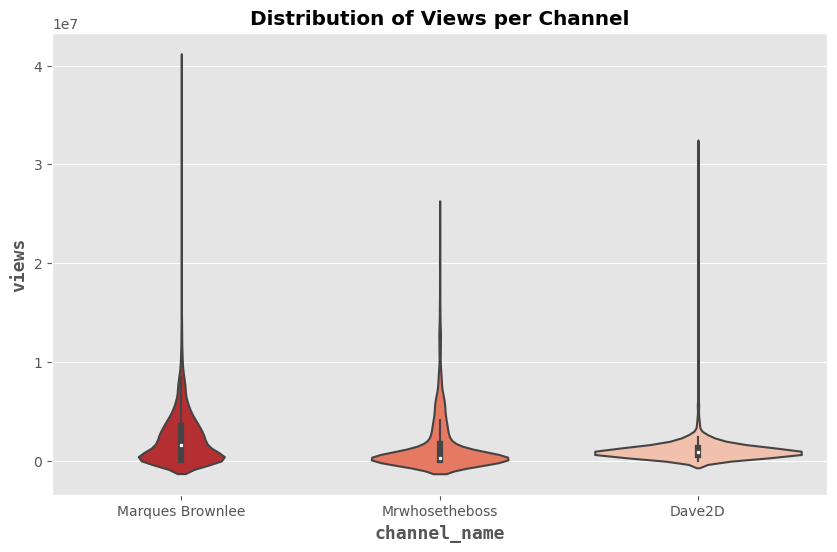

In [34]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='channel_name', y='view_count', palette='Reds_r')
plt.title('Distribution of Views per Channel', weight='bold')
plt.xlabel('channel_name', fontdict=fontdict)
plt.ylabel('views', fontdict=fontdict);

There's higher variation in number of views for Marques Brownlee and Mrwhosetheboss compared to Dave2d. Both of them have a lot of videos whose number of views are way higher than the median (represented by the white dot). On the other hand, when we look at Dave2d, the upper 50% of his videos have views that are not too far away from the median. The exact median number of views for all channels can be seen here:

In [35]:
df.groupby('channel_name')['view_count'].describe()[['50%']]

,50%
channel_name,
Dave2D,861994.0
Marques Brownlee,1530296.0
Mrwhosetheboss,222985.5


## Views, Likes and Comments per Minute Video

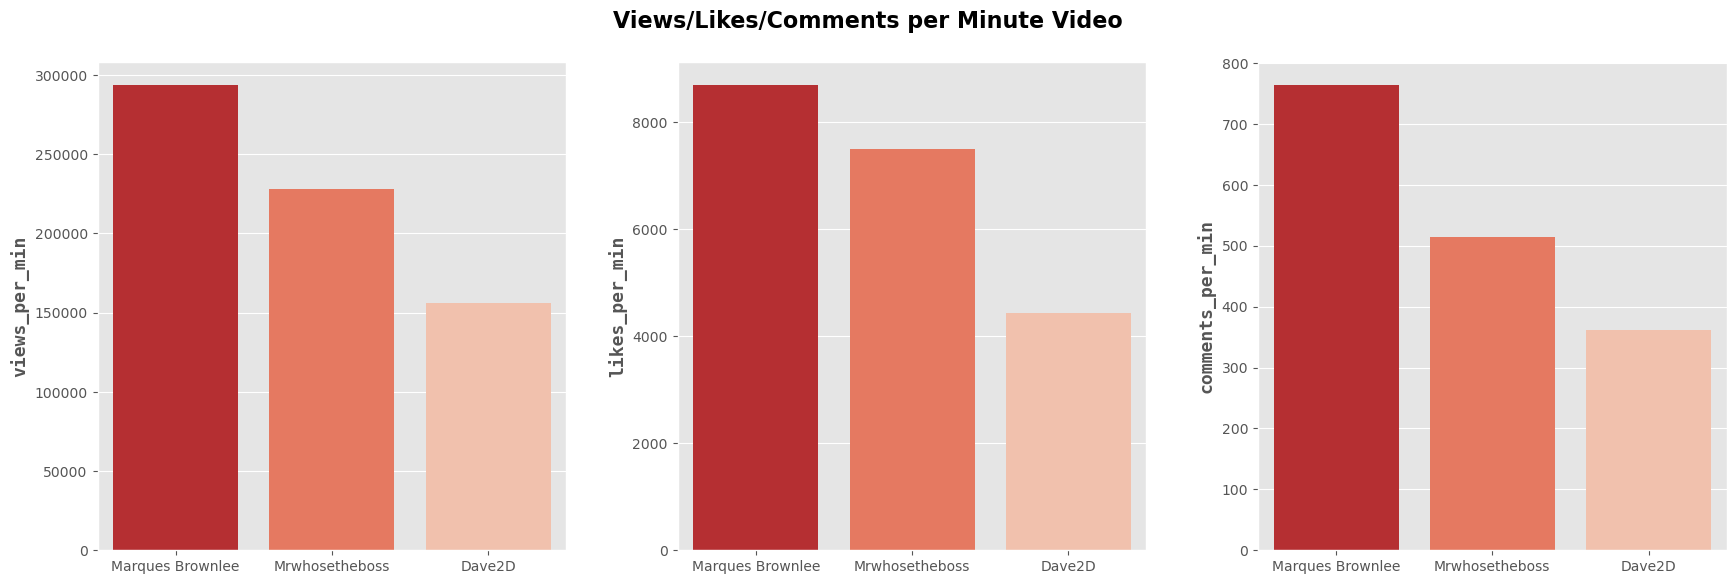

In [36]:
numbers_per_min = df.groupby('channel_name').sum().sort_values('view_count', ascending=False)
numbers_per_min['views_per_min'] = numbers_per_min.view_count/(numbers_per_min.duration_secs/60)
numbers_per_min['likes_per_min'] = numbers_per_min.like_count/(numbers_per_min.duration_secs/60)
numbers_per_min['comments_per_min'] = numbers_per_min.comment_count/(numbers_per_min.duration_secs/60)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=numbers_per_min, x=numbers_per_min.index, y='views_per_min', ax=axes[0], palette='Reds_r')
axes[0].set_xlabel(None)
axes[0].set_ylabel('views_per_min', fontdict=fontdict)

sns.barplot(data=numbers_per_min, x=numbers_per_min.index, y='likes_per_min', ax=axes[1], palette='Reds_r')
axes[1].set_xlabel(None)
axes[1].set_ylabel('likes_per_min', fontdict=fontdict)

sns.barplot(data=numbers_per_min, x=numbers_per_min.index, y='comments_per_min', ax=axes[2], palette='Reds_r')
axes[2].set_xlabel(None)
axes[2].set_ylabel('comments_per_min', fontdict=fontdict)

fig.tight_layout(pad=3)
plt.suptitle('Views/Likes/Comments per Minute Video', size=16, weight='bold', y=1.01)
plt.show()

We have seen previously that each of Marques Brownlee and Mrwhosetheboss have more than triple the amount of views on their channels compared to Dave2d, but that may also be because they have uploaded more than double the amount of videos that Dave2d has. However, when we look at the number of views per minute video, both of them still accumulate more views, except the difference is not as massive as before. They also amass more likes and comments per minute compared to Dave2D.
This may come back to the fact that both Marques Brownlee and Mrwhosetheboss have way more subscribers, so more people are likely to view, like and comment on their content.

## Views vs Video Duration

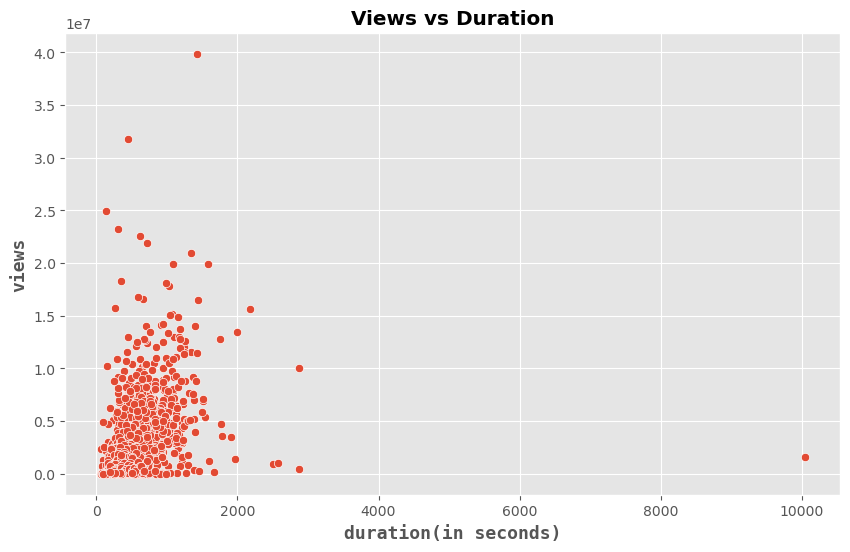

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='duration_secs', y='view_count')
plt.title('Views vs Duration', weight='bold')
plt.xlabel('duration(in seconds)', fontdict=fontdict)
plt.ylabel('views', fontdict=fontdict);

The scatterplot above shows the relationship between number of views and video duration. As we can see, there is no clear correlation between the two. An increase in video length does not necessarily mean an increase in the number of views.

## Views, Likes and Comments by Month

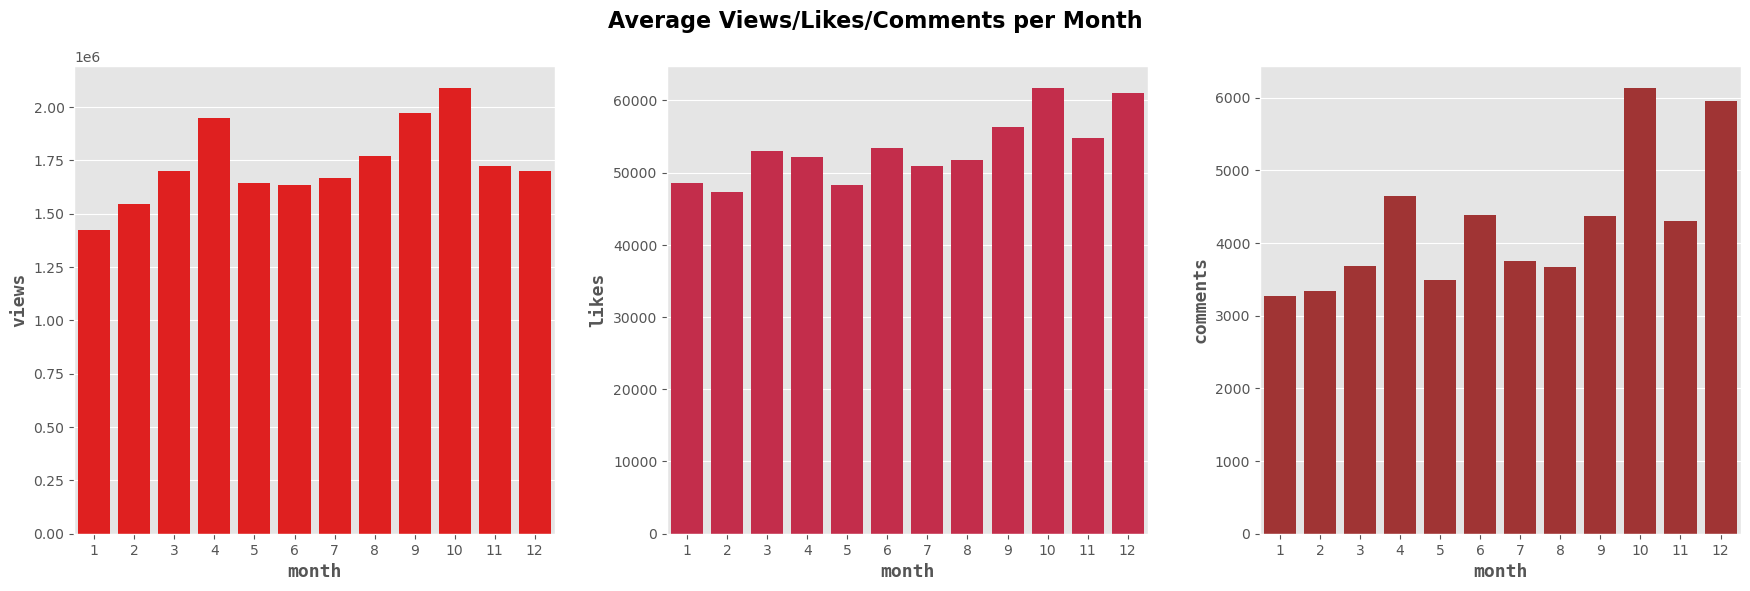

In [38]:
numbers_by_month = df.groupby('month')[['view_count', 'like_count', 'comment_count']].mean().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=numbers_by_month, x='month', y='view_count', color='red', ax=axes[0])
axes[0].set_xlabel('month', fontdict=fontdict)
axes[0].set_ylabel('views', fontdict=fontdict)

sns.barplot(data=numbers_by_month, x='month', y='like_count', color='crimson', ax=axes[1])
axes[1].set_xlabel('month', fontdict=fontdict)
axes[1].set_ylabel('likes', fontdict=fontdict)

sns.barplot(data=numbers_by_month, x='month', y='comment_count', color='firebrick', ax=axes[2])
axes[2].set_xlabel('month', fontdict=fontdict)
axes[2].set_ylabel('comments', fontdict=fontdict)

fig.tight_layout(pad=2.5)
plt.suptitle('Average Views/Likes/Comments per Month', size=16, weight='bold', y=1.01)
plt.show()

On average, videos posted on October have the highest number of views, likes and comments. Videos uploaded at the end of the year generally get more interactions compared to videos uploaded at the start of the year.

## Number of Videos Uploaded per Month per Year

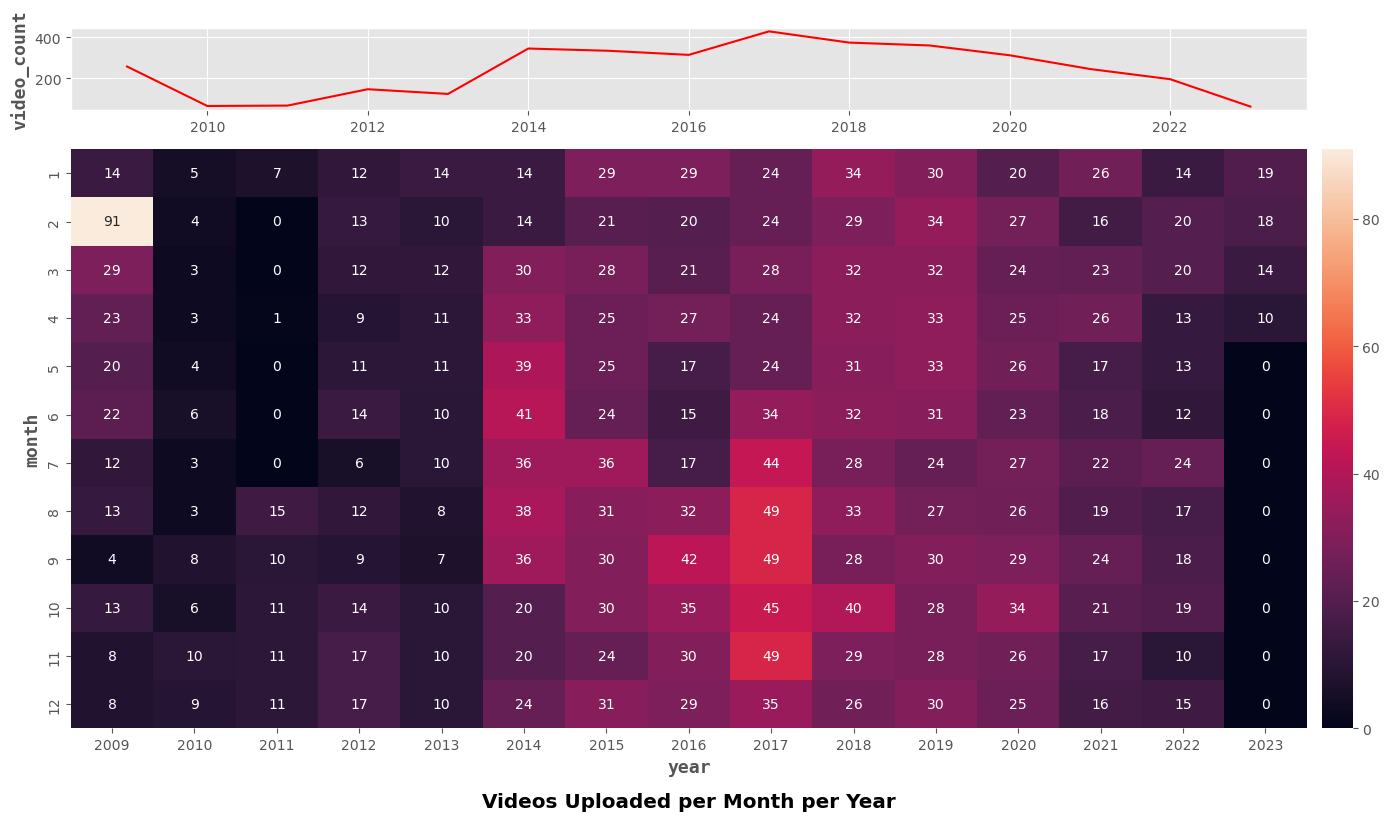

In [39]:
videos_by_year = df.groupby('year')['view_count'].agg(['sum', 'count']).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [1, 7], 'width_ratios': [20, 0.5]})

sns.lineplot(data=videos_by_year, x='year', y='count', color='red', ax=axes[0,0])
axes[0,0].set_xlabel(None)
axes[0,0].set_ylabel('video_count', fontdict=fontdict)

axes[0,1].axis('off')

sns.heatmap(df.groupby(['year', 'month'])[['video_id']].count().reset_index()
            .pivot('month', 'year', 'video_id').fillna('0').astype(int), annot=True, cbar_ax=axes[1,1], ax=axes[1,0])
axes[1,0].set_title('Videos Uploaded per Month per Year', weight='bold', y=-0.15)
axes[1,0].set_xlabel('year', fontdict=fontdict)
axes[1,0].set_ylabel('month', fontdict=fontdict)

plt.tight_layout()
plt.show()

We can observe a streak of bright red rectangles from July to November in 2017, where more than 40 videos were posted each month, the same year where the amount of videos uploaded was at its peak, as can be seen from the line chart above. Since then, less and less videos have been posted each year. We'll investigate how this affects the total views per year later.

It is also interesting to note that in February 2009, an enormous amount  of 91 videos were uploaded by Marques Brownlee alone (we know that Mrwhosetheboss and Dave2D only started uploading since 2011 and 2015, respectively).

In [40]:
len(df.query('channel_name=="Marques Brownlee" & year==2009 & month==2'))

91

## Number of Views and Videos per Year

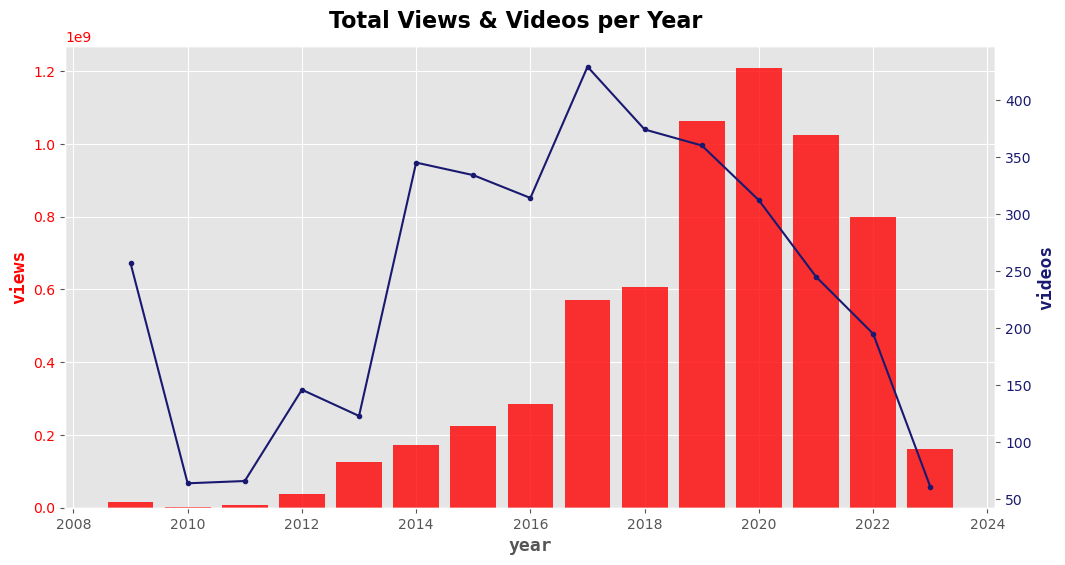

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.bar(videos_by_year.year, videos_by_year['sum'], color='red', alpha=0.8)
ax1.set_xlabel('year', fontdict=fontdict)
ax1.set_ylabel('views', color='red', fontdict=fontdict)
ax1.tick_params(axis='y', labelcolor='red')
#ax1.grid(False)

ax2.plot(videos_by_year.year, videos_by_year['count'], color='midnightblue', lw=1.5, marker='.')
ax2.set_ylabel('videos', color='midnightblue', fontdict=fontdict)
ax2.tick_params(axis='y', labelcolor='midnightblue')
ax2.grid(False)

fig.suptitle('Total Views & Videos per Year', size=16, weight='bold', y=0.94)
plt.show()

We have seen that the number of videos uploaded hit its peak in 2017, and has since been falling. But this is not the case with the total views, as the number of views kept on increasing up until 2020, even with less and less videos were being uploaded. For example, videos posted in 2020 garnered more than double the number of views compared to videos posted in 2017, despite having lower number of videos (312 videos in 2020 vs 429 videos in 2017).  

In [42]:
df.groupby('year').size().loc[[2017, 2020]].to_frame()

,0
year,
2017,429
2020,312


## Most Used Words in Video Titles

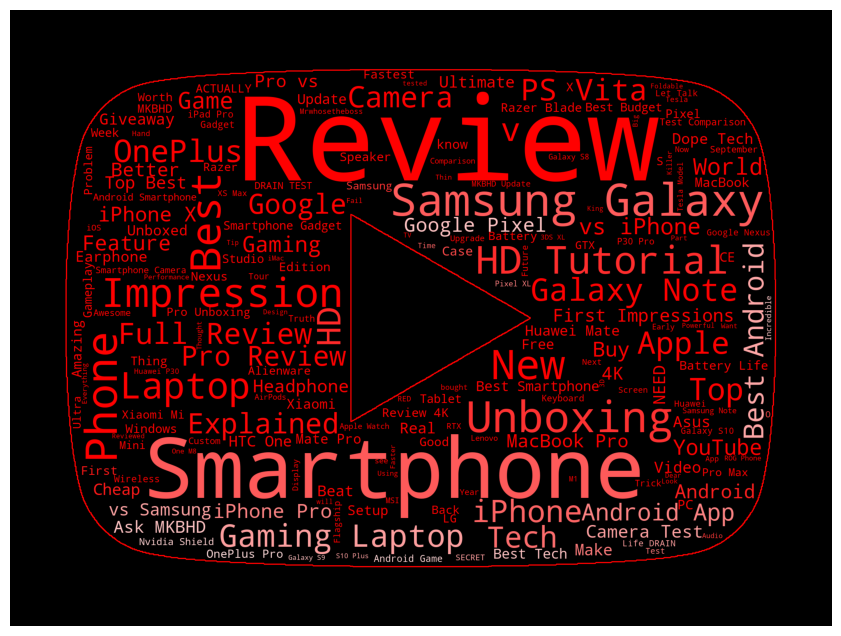

In [43]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import PIL.Image

text = ' '.join(df['video_title'])
mask = np.array(PIL.Image.open('ytlogo1.png'))
colormap = ImageColorGenerator(mask)

wc = WordCloud(stopwords=STOPWORDS,
               mask=mask,
               background_color='black',
               contour_color='red',
               contour_width=1.5,
               max_words=200
               ).generate(text)

wc.recolor(color_func=colormap)
plt.figure(figsize=(14,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

The two most common words found in video titles are "review" and "smartphone". We can also see that smartphone brands such as "Samsung", "Apple" and "OnePlus" are being used a lot in video titles. Other than smartphone-related words, there are also "laptop", "camera", "PS Vita"(a game console) and "headphone".

## Number of Viral Videos per Month

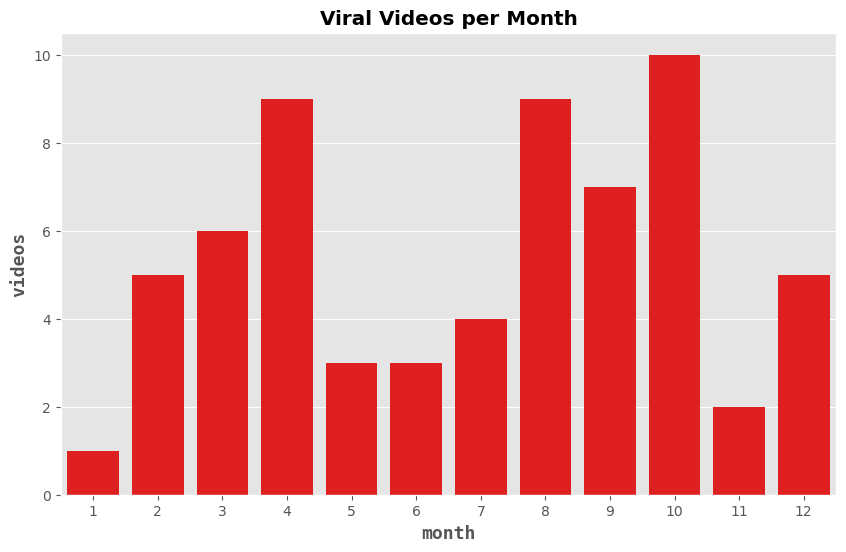

In [44]:
viral_videos = df.query('view_count > 10_000_000').groupby('month')[['video_id']].count()
plt.figure(figsize=(10, 6))
sns.barplot(data=viral_videos, x=viral_videos.index, y='video_id', color='red')
plt.title('Viral Videos per Month', weight='bold')
plt.xlabel('month', fontdict=fontdict)
plt.ylabel('videos', fontdict=fontdict);

Here we consider videos with more than 10 million views as viral. As we can see, October has the most number of viral videos with 10 and January has the least with 1.

## Top 10 Most Viewed/Liked/Commented Videos

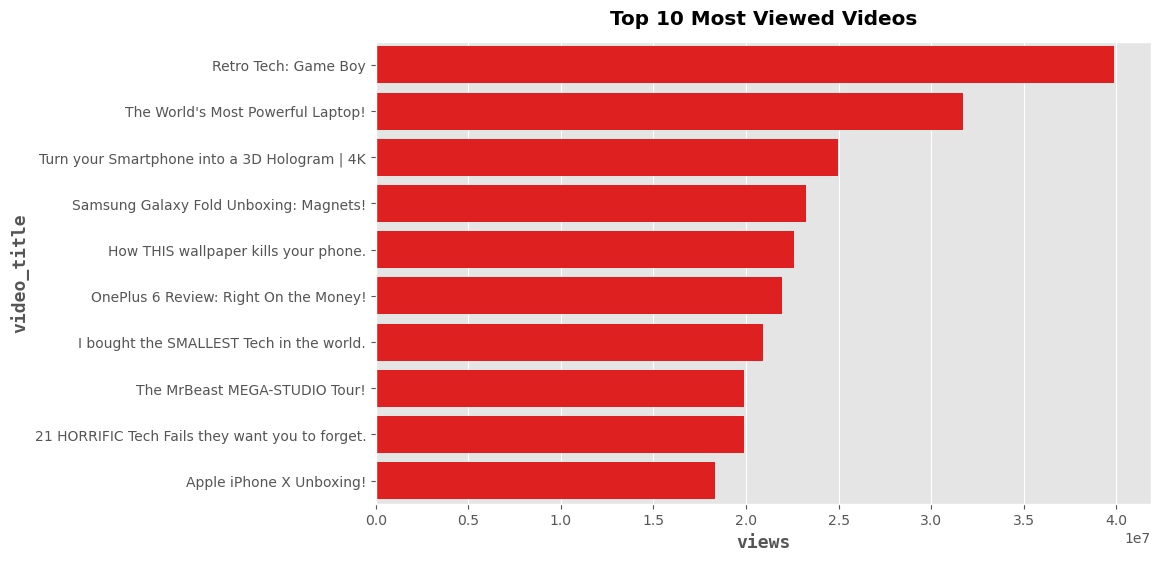

In [45]:
most_viewed = df.sort_values('view_count', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=most_viewed, x='view_count', y='video_title', color='red')
plt.title('Top 10 Most Viewed Videos', weight='bold', y=1.02)
plt.xlabel('views', fontdict=fontdict)
plt.ylabel('video_title', fontdict=fontdict);

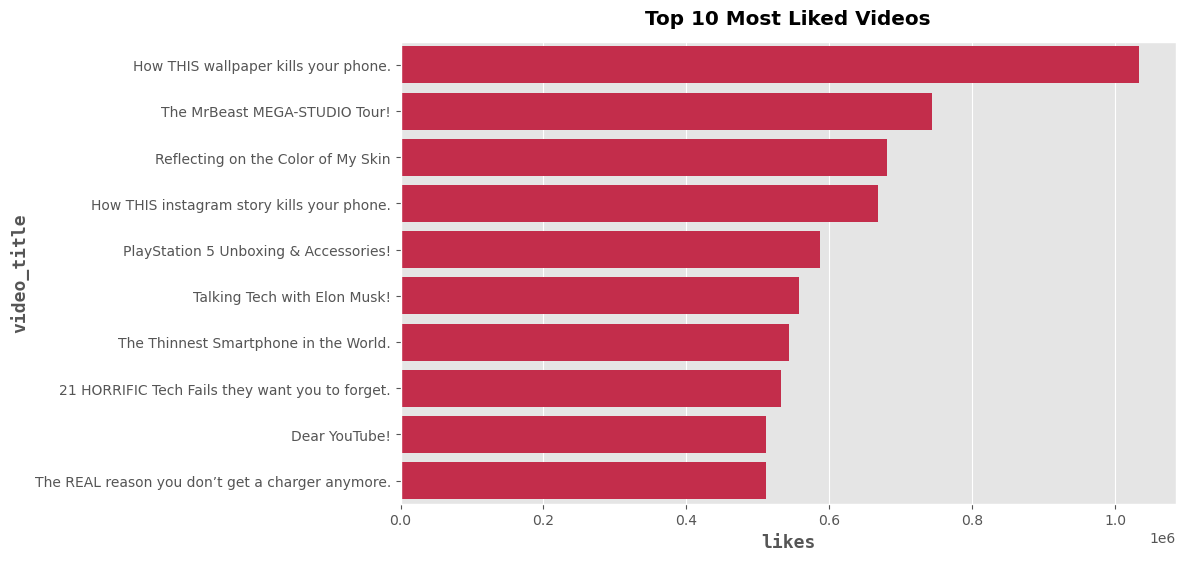

In [46]:
most_liked = df.sort_values('like_count', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=most_liked, x='like_count', y='video_title', color='crimson')
plt.title('Top 10 Most Liked Videos', weight='bold', y=1.02)
plt.xlabel('likes', fontdict=fontdict)
plt.ylabel('video_title', fontdict=fontdict);

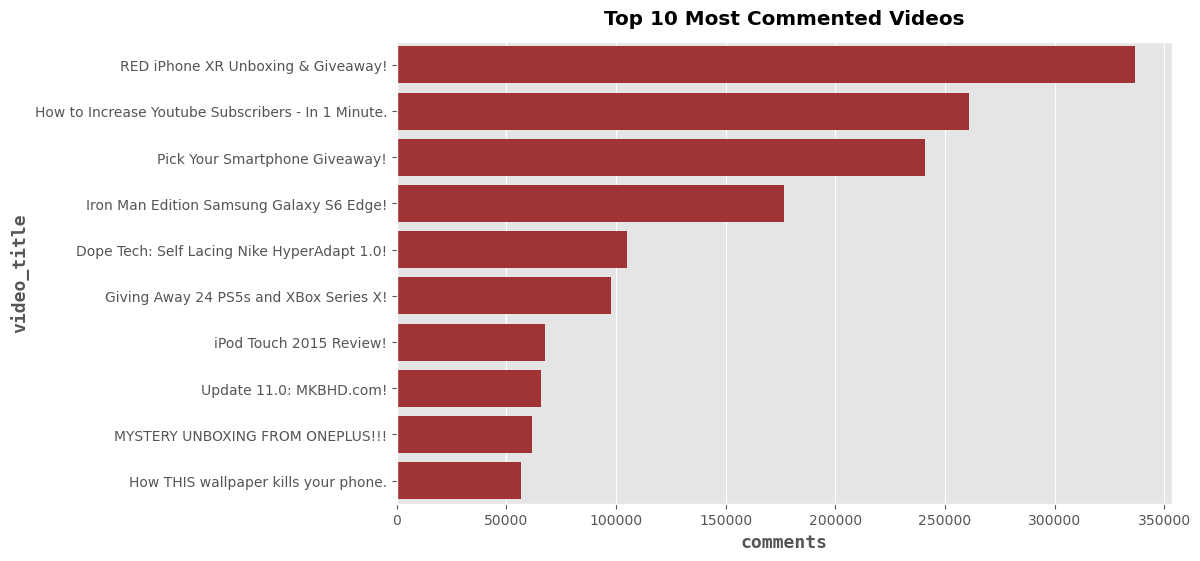

In [47]:
most_commented = df.sort_values('comment_count', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=most_commented, x='comment_count', y='video_title', color='firebrick')
plt.title('Top 10 Most Commented Videos', weight='bold', y=1.02)
plt.xlabel('comments', fontdict=fontdict)
plt.ylabel('video_title', fontdict=fontdict);

Only this one video by Mrwhosetheboss makes it to the top 10 of all 3 categories.

In [48]:
most_viewed.merge(most_liked, on='video_title').merge(most_commented, on='video_title') \
[['video_title', 'channel_name', 'view_count', 'like_count', 'comment_count']]

,video_title,channel_name,view_count,like_count,comment_count
0,How THIS wallpaper kills your phone.,Mrwhosetheboss,22574961,1032393,56594


# CONCLUSION

Here is a summary of what we've discovered from this analysis:

- Marques Brownlee is the biggest YouTube channel of the three, with the highest number of subscribers and total views. Mrwhosetheboss is a close second, followed by Dave2D as the smallest channel.
- Marques Brownlee has the most views, likes and comments per minute video and Dave2D has the least in all 3 categories. 
- There's no clear correlation between video duration and number of views.
- Most of the videos are less than 2000s (~33m) long.
- Videos uploaded at the end of the year average higher number of views, likes and comments compared to videos uploaded at the start of the year.
- 2017 saw the highest number of videos uploaded.
- Videos uploaded in 2020 have the highest number of total views. 
- The two most used words in video titles are "review" and "smartphone".